In [1]:
from google.colab import files
uploaded = files.upload()  # Select .env file from local PC

Saving .env to .env


In [2]:
pip install python-dotenv

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  # load variables from .env

print("DEBUG: DB_HOST =", os.getenv("DB_HOST"))

DEBUG: DB_HOST = mysql-dianxiang251126-firewaking-tinkersmith.g.aivencloud.com


In [4]:
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")

print(DB_HOST, DB_PORT, DB_USER)  # Should print actual values

mysql-dianxiang251126-firewaking-tinkersmith.g.aivencloud.com 15058 avnadmin


In [5]:
# -*- coding: utf-8 -*-
!pip install requests beautifulsoup4 mysql-connector-python --quiet

import requests
from bs4 import BeautifulSoup
import mysql.connector
from mysql.connector import Error

class MySQLHelper:
    def __init__(self, host, port, user, password, database):
        self.conn = mysql.connector.connect(
            host=host,
            port=port,
            user=user,
            password=password,
            database=database,
            charset='utf8mb4'
        )
        self.cursor = self.conn.cursor()

    def create_movie_table(self):
        create_sql = """
        CREATE TABLE IF NOT EXISTS douban_top100_movies (
            id INT AUTO_INCREMENT PRIMARY KEY,
            movie_rank INT NOT NULL,
            title VARCHAR(500),
            url VARCHAR(1000),
            fetched_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        ) CHARACTER SET = utf8mb4;
        """
        self.cursor.execute(create_sql)
        self.conn.commit()

    def insert_movie(self, rank, title, url):
        insert_sql = """
        INSERT INTO douban_top100_movies (movie_rank, title, url) VALUES (%s, %s, %s);

        """
        self.cursor.execute(insert_sql, (rank, title, url))
        self.conn.commit()

    def fetch_all(self):
        self.cursor.execute("SELECT * FROM douban_top100_movies;")
        rows = self.cursor.fetchall()
        return rows

    def close(self):
        self.cursor.close()
        self.conn.close()

import requests
from bs4 import BeautifulSoup

def fetch_douban_list(url):
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }

    resp = requests.get(url, headers=headers, timeout=10)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')

    items = soup.select("div.doulist-item")
    results = []

    for item in items:
        # title
        title_tag = item.select_one("div.doulist-subject div.title a")
        title = title_tag.get_text(strip=True) if title_tag else ""

        # movie URL
        url_link = title_tag["href"] if title_tag else ""

        results.append({
            "title": title,
            "url": url_link,
        })

    return results

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 76.0 MB/s eta 0:00:00


In [6]:
import requests
from bs4 import BeautifulSoup
import time
import mysql.connector

# --------------------------
# FETCH METADATA FUNCTION
# --------------------------
HEADERS = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/120.0.0.0 Safari/537.36'
    )
}

def fetch_metadata(douban_url):
    resp = requests.get(douban_url, headers=HEADERS, timeout=10)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')

    info_div = soup.find('div', id='info')
    if info_div is None:
        return None, None

    genres = [
        span.get_text(strip=True)
        for span in info_div.find_all("span", property="v:genre")
    ]

    country = None
    for s in info_div.stripped_strings:
        if s.startswith("制片国家/地区"):
            parts = s.split(":", 1)
            if len(parts) == 2:
                country = parts[1].strip()
            break

    return genres, country

# --------------------------
# CONNECT TO AIVEN MYSQL WITHOUT CA
# --------------------------
conn = mysql.connector.connect(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    # charset='utf8mb4',
    ssl_disabled=True  # <-- disables SSL verification
)

cursor = conn.cursor()

# ---- Add missing columns safely ----
def add_column_if_missing(cursor, table, column, definition):
    cursor.execute(f"""
        SELECT COUNT(*)
        FROM INFORMATION_SCHEMA.COLUMNS
        WHERE TABLE_SCHEMA = DATABASE()
        AND TABLE_NAME = '{table}'
        AND COLUMN_NAME = '{column}';
    """)
    exists = cursor.fetchone()[0]
    if exists == 0:
        cursor.execute(f"ALTER TABLE {table} ADD COLUMN {column} {definition};")
        print(f"Added column: {column}")

add_column_if_missing(cursor, "douban_top100_movies", "genres", "TEXT")
add_column_if_missing(cursor, "douban_top100_movies", "country", "VARCHAR(200)")
conn.commit()

cursor.close()
conn.close()
print("Done!")

Done!


In [7]:
import os

print("DB_HOST:", DB_HOST)
print("DB_PORT:", DB_PORT)
print("DB_USER:", DB_USER)
print("DB_NAME:", DB_NAME)

import socket
try:
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(5)
    sock.connect((DB_HOST, DB_PORT))
    print("TCP connection test: SUCCESS")
    sock.close()
except Exception as e:
    print("TCP connection test: FAILED:", e)

DB_HOST: mysql-dianxiang251126-firewaking-tinkersmith.g.aivencloud.com
DB_PORT: 15058
DB_USER: avnadmin
DB_NAME: defaultdb
TCP connection test: FAILED: 'str' object cannot be interpreted as an integer


In [8]:
from dotenv import load_dotenv
import os
import socket

load_dotenv()  # assuming .env is in current working directory

DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")  # string

print("DEBUG: DB_HOST =", DB_HOST)
print("DEBUG: DB_PORT =", DB_PORT)

if not DB_HOST or not DB_PORT:
    raise RuntimeError("DB_HOST or DB_PORT not set — check .env")

# convert port to int
port = int(DB_PORT)

# test TCP connection
sock = socket.socket()
sock.settimeout(5)

try:
    sock.connect((DB_HOST, port))
    print("TCP reachability test: SUCCESS — host reachable")
except Exception as e:
    print("TCP reachability test: FAILED —", e)
finally:
    sock.close()

DEBUG: DB_HOST = mysql-dianxiang251126-firewaking-tinkersmith.g.aivencloud.com
DEBUG: DB_PORT = 15058
TCP reachability test: SUCCESS — host reachable


In [9]:
# Then connect:
conn = mysql.connector.connect(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    charset='utf8mb4'
)

In [10]:

if __name__ == "__main__":
    urls = [
       "https://www.douban.com/doulist/197174/",
       "https://www.douban.com/doulist/197174/?start=25&sort=time&playable=0&sub_type="
    ]

    helper = MySQLHelper(
    host=DB_HOST,
    port=int(DB_PORT),
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    )

    # 1. Create the table
    helper.create_movie_table()

    rank_counter = 1   # ← create rank here

    for url in urls:
        movies = fetch_douban_list(url)
        for m in movies:
            helper.insert_movie(rank_counter, m['title'], m['url'])

            rank_counter += 1

    # print("Inserted {} entries".format(len(hot10)))
    print("Inserted", rank_counter - 1, "movies.")
     # 3. Fetch everything and print
    all_rows = helper.fetch_all()
    for row in all_rows:
        print(row)

Inserted 50 movies.
(1, 1, '热情如火 Some Like It Hot', 'https://movie.douban.com/subject/1292574/', datetime.datetime(2025, 11, 30, 8, 1, 58), None, None)
(2, 2, '现代启示录 Apocalypse Now', 'https://movie.douban.com/subject/1292260/', datetime.datetime(2025, 11, 30, 8, 1, 58), None, None)
(3, 3, '绿野仙踪 The Wizard of Oz', 'https://movie.douban.com/subject/1292625/', datetime.datetime(2025, 11, 30, 8, 1, 59), None, None)
(4, 4, '超级无敌掌门狗：引鹅入室 Wallace & Gromit: The Wrong Trousers', 'https://movie.douban.com/subject/1293834/', datetime.datetime(2025, 11, 30, 8, 1, 59), None, None)
(5, 5, '唐人街 Chinatown', 'https://movie.douban.com/subject/1293889/', datetime.datetime(2025, 11, 30, 8, 1, 59), None, None)
(6, 6, "雨中曲 Singin' in the Rain", 'https://movie.douban.com/subject/1293460/', datetime.datetime(2025, 11, 30, 8, 1, 59), None, None)
(7, 7, '黄金三镖客 Il buono, il brutto, il cattivo', 'https://movie.douban.com/subject/1401118/', datetime.datetime(2025, 11, 30, 8, 1, 59), None, None)
(8, 8, '愤怒的公牛 Ragin

VISUALIZATION PART (CHECKING)

In [11]:
import requests
from bs4 import BeautifulSoup

!pip install deep-translator
from deep_translator import GoogleTranslator

url = "https://www.douban.com/doulist/197174/"
resp = requests.get(url, headers={"User-Agent":"Mozilla/5.0"})
soup = BeautifulSoup(resp.text, "lxml")

movies = []
for item in soup.select("div.bd.doulist-subject"):
    title_cn = item.select_one("div.title").get_text(strip=True)
    source_cn = item.select_one("div.source").get_text(strip=True)
    post_cn = item.select_one("div.post").get_text(strip=True)
    rating_cn = item.select_one("div.rating").get_text(strip=True)
    abstract_cn = item.select_one("div.abstract").get_text(strip=True)

    title_en = GoogleTranslator(source='auto', target='en').translate(title_cn)
    source_en = GoogleTranslator(source='auto', target='en').translate(source_cn)
    post_en = GoogleTranslator(source='auto', target='en').translate(post_cn)
    rating_en = GoogleTranslator(source='auto', target='en').translate(rating_cn)
    abstract_en = GoogleTranslator(source='auto', target='en').translate(abstract_cn)

    movies.append({"title": title_en,
                   "source": source_en,
                   "post": post_en,
                   "rating": rating_en,
                   "abstract": abstract_en})

import pandas as pd
df = pd.DataFrame(movies)
# plot using df — labels are in English, so normal fonts work

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.9 MB/s eta 0:00:00


In [12]:
import uuid
cookie_id = str(uuid.uuid4())[:8]

headers = {
    "User-Agent": "...",
    "Referer": "https://movie.douban.com/",
    "Cookie": f"bid={cookie_id};"
}

def fetch_movie_detail(url):
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Referer": "https://movie.douban.com/",
    }

    resp = requests.get(url, headers=headers, timeout=10)
    resp.raise_for_status()

    soup = BeautifulSoup(resp.text, "html.parser")

    # Genres
    genres = [g.get_text(strip=True) for g in soup.select('span[property="v:genre"]')]
    genres = ",".join(genres)

    # Country / region
    country = ""
    info = soup.select_one("#info")
    if info:
        for line in info.text.split("\n"):
            if "制片国家/地区" in line:
                country = line.split(":")[-1].strip()
                break

    return {"genres": genres, "country": country}

In [13]:
helper.cursor.execute("SHOW COLUMNS FROM douban_top100_movies;")
helper.cursor.fetchall()

[('id', 'int', 'NO', 'PRI', None, 'auto_increment'),
 ('movie_rank', 'int', 'NO', '', None, ''),
 ('title', 'varchar(500)', 'YES', '', None, ''),
 ('url', 'varchar(1000)', 'YES', '', None, ''),
 ('fetched_at',
  'timestamp',
  'YES',
  '',
  'CURRENT_TIMESTAMP',
  'DEFAULT_GENERATED'),
 ('genres', 'text', 'YES', '', None, ''),
 ('country', 'varchar(300)', 'YES', '', None, '')]

In [14]:
query = "SELECT title, genres, country FROM douban_top100_movies;"
helper.cursor.execute(query)
rows = helper.cursor.fetchall()

In [15]:
import pandas as pd
df = pd.DataFrame(rows, columns=['names' , 'genres', 'regions'])
# Split genres if multiple
df_exploded = df.assign(genre = df['genres'].str.split(',')).explode('genre')
genre_counts = df_exploded['genre'].value_counts()

In [16]:
import requests
from bs4 import BeautifulSoup
import uuid

def fetch_movie_detail(url):
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/121.0.0.0 Safari/537.36"
        ),
        "Referer": "https://movie.douban.com/",
        "Cookie": f"bid={uuid.uuid4().hex[:10]};"
    }

    resp = requests.get(url, headers=headers, timeout=10)
    resp.raise_for_status()

    soup = BeautifulSoup(resp.text, "html.parser")

    # ---------- GENRES ----------
    genres = [g.get_text(strip=True) for g in soup.select('span[property="v:genre"]')]
    genres = ",".join(genres) if genres else None

    # ---------- REGION ----------
    region = None
    info = soup.select_one("#info")
    if info:
        lines = info.text.split("\n")
        for line in lines:
            if "制片国家/地区" in line:
                region = line.split(":")[-1].strip()
                break

    return {"genres": genres, "region": region}

In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import uuid

urls = [
    "https://www.douban.com/doulist/197174/",
    "https://www.douban.com/doulist/197174/?start=25&sort=time&playable=0&sub_type="
]

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/121.0.0.0 Safari/537.36"
    ),
    "Referer": "https://movie.douban.com/",
    "Cookie": f"bid={uuid.uuid4().hex[:10]};"
}

movies = []

for url in urls:
    resp = requests.get(url, headers=headers, timeout=10)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    # Loop through each movie block
    for movie_div in soup.select("div.bd.doulist-subject"):
        title_tag = movie_div.select_one("div.title")
        title = title_tag.get_text(strip=True).lstrip("•").strip() if title_tag else None

        abstract_tag = movie_div.select_one("div.abstract")
        genres = region = director = actors = year = None

        if abstract_tag:
            lines = [line.strip() for line in abstract_tag.stripped_strings]
            for line in lines:
                if line.startswith("导演:"):
                    director = line.replace("导演:", "").strip()
                elif line.startswith("主演:"):
                    actors = line.replace("主演:", "").strip()
                elif line.startswith("类型:"):
                    genres = line.replace("类型:", "").strip()
                elif line.startswith("制片国家/地区:"):
                    region = line.replace("制片国家/地区:", "").strip()
                elif line.startswith("年份:"):
                    year = line.replace("年份:", "").strip()

        # Rating
        rating_tag = movie_div.select_one("div.rating span.rating_nums")
        rating = float(rating_tag.get_text(strip=True)) if rating_tag else None

        movies.append({
            "title": title,
            "director": director,
            "actors": actors,
            "genres": genres,
            "region": region,
            "year": year,
            "rating": rating
        })

# Convert to DataFrame
df = pd.DataFrame(movies)
print(df.head())

                                               title     director  \
0                              热情如火 Some Like It Hot       比利·怀尔德   
1                               现代启示录 Apocalypse Now  弗朗西斯·福特·科波拉   
2                              绿野仙踪 The Wizard of Oz      维克多·弗莱明   
3  超级无敌掌门狗：引鹅入室 Wallace & Gromit: The Wrong Trousers        尼克·帕克   
4                                      唐人街 Chinatown      罗曼·波兰斯基   

                     actors             genres region  year  rating  
0   玛丽莲·梦露 / 托尼·柯蒂斯 / 杰克·莱蒙                 喜剧     美国  1959     8.9  
1   马丁·辛 / 马龙·白兰度 / 罗伯特·杜瓦尔            剧情 / 战争     美国  1979     8.5  
2    朱迪·加兰 / 弗兰克·摩根 / 雷·博尔格       歌舞 / 奇幻 / 冒险     美国  1939     8.2  
3                    彼得·萨利斯       喜剧 / 动画 / 短片     英国  1993     8.9  
4  杰克·尼科尔森 / 费·唐纳薇 / 约翰·休斯顿  犯罪 / 剧情 / 悬疑 / 惊悚     美国  1974     8.4  


In [19]:
urls = [
    "https://www.douban.com/doulist/197174/",
    "https://www.douban.com/doulist/197174/?start=25&sort=time&playable=0&sub_type=",

]

import requests
from bs4 import BeautifulSoup
import pandas as pd
import uuid

def fetch_movies_from_page(url):
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/121.0.0.0 Safari/537.36"
        ),
        "Referer": "https://movie.douban.com/",
        "Cookie": f"bid={uuid.uuid4().hex[:10]};"
    }

    resp = requests.get(url, headers=headers, timeout=10)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    movies = []
    for item in soup.select("div.bd.doulist-subject"):
        title = item.select_one("div.title").get_text(strip=True) if item.select_one("div.title") else None
        abstract = item.select_one("div.abstract")

        director = actors = genres = region = year = rating = None

        if abstract:
            text_lines = abstract.get_text(separator="\n").split("\n")
            for line in text_lines:
                line = line.strip()
                if line.startswith("导演:"):
                    director = line.replace("导演:", "").strip()
                elif line.startswith("主演:"):
                    actors = line.replace("主演:", "").strip()
                elif line.startswith("类型:"):
                    genres = line.replace("类型:", "").strip()
                elif line.startswith("制片国家/地区:"):
                    region = line.replace("制片国家/地区:", "").strip()
                elif line.startswith("年份:"):
                    year = line.replace("年份:", "").strip()

        rating_tag = item.select_one("div.rating")
        rating = rating_tag.get_text(strip=True) if rating_tag else None

        movies.append([title, director, actors, genres, region, year, rating, url])
    return movies

all_movies = []
for u in urls:
    all_movies.extend(fetch_movies_from_page(u))

# Build DataFrame
columns = ["title", "director", "actors", "genres", "region", "year", "rating", "url"]
df = pd.DataFrame(all_movies, columns=columns)

In [20]:
import pandas as pd

# Get first 6 rows
first_six = df.head(6)

# Get the last row
last_row = df.tail(1)

# Combine them
subset = pd.concat([first_six, last_row])

print(subset)

                                                title        director  \
0                               热情如火 Some Like It Hot          比利·怀尔德   
1                                现代启示录 Apocalypse Now     弗朗西斯·福特·科波拉   
2                               绿野仙踪 The Wizard of Oz         维克多·弗莱明   
3   超级无敌掌门狗：引鹅入室 Wallace & Gromit: The Wrong Trousers           尼克·帕克   
4                                       唐人街 Chinatown         罗曼·波兰斯基   
5                             雨中曲 Singin' in the Rain  斯坦利·多南 / 吉恩·凯利   
49                                   教父 The Godfather     弗朗西斯·福特·科波拉   

                      actors             genres region  year           rating  \
0    玛丽莲·梦露 / 托尼·柯蒂斯 / 杰克·莱蒙                 喜剧     美国  1959    8.9(80940人评价)   
1    马丁·辛 / 马龙·白兰度 / 罗伯特·杜瓦尔            剧情 / 战争     美国  1979   8.5(126948人评价)   
2     朱迪·加兰 / 弗兰克·摩根 / 雷·博尔格       歌舞 / 奇幻 / 冒险     美国  1939    8.2(59408人评价)   
3                     彼得·萨利斯       喜剧 / 动画 / 短片     英国  1993    8.9(16829人评价)   
4   杰克·尼科尔

<BarContainer object of 50 artists>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21916 (\N{CJK UNIFIED IDEOGRAPH-559C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21095 (\N{CJK UNIFIED IDEOGRAPH-5267}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27468 (\N{CJK UNIFIED IDEOGRAPH-6B4C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 33310 (\N{CJK UNIFIED IDEOGRAPH-821E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph

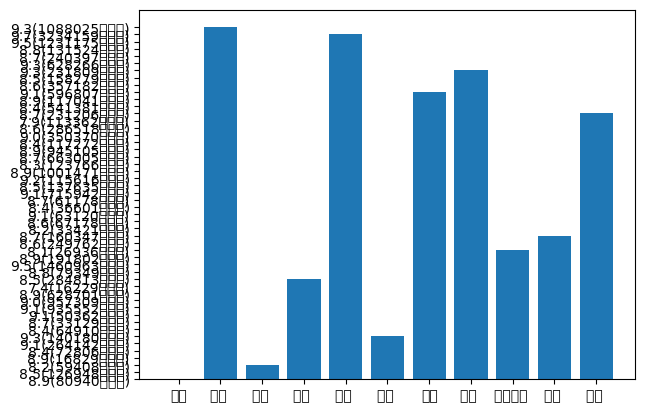

In [22]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

df['main_genre'] = df['genres'].str.split('/').str[0]
plt.bar(df['main_genre'], df['rating'])

In [23]:
movies = soup.find_all("div", class_="doulist-subject")  # adjust class based on actual HTML
print(f"Found {len(movies)} movies")

Found 25 movies


In [24]:
import re

data = []
for movie in movies:
    title_tag = movie.find("div", class_="title")
    rating_tag = movie.find("div", class_="rating")
    abstract_tag = movie.find("div", class_="abstract")

    title = title_tag.get_text(strip=True) if title_tag else None

    # Extract numeric rating using regex
    rating_text = rating_tag.get_text(strip=True) if rating_tag else None
    rating = float(re.search(r"[\d.]+", rating_text).group()) if rating_text else None

    abstract = abstract_tag.get_text(strip=True) if abstract_tag else None

    data.append({
        "title": title,
        "rating": rating,
        "abstract": abstract
    })

import pandas as pd
df = pd.DataFrame(data)
print(df.head())

                            title  rating  \
0      阿拉伯的劳伦斯 Lawrence of Arabia     8.7   
1      拯救大兵瑞恩 Saving Private Ryan     9.1   
2                  好家伙 GoodFellas     8.5   
3     生活多美好 It's a Wonderful Life     9.2   
4  沉默的羔羊 The Silence of the Lambs     8.9   

                                            abstract  
0  导演: 大卫·里恩主演: 彼得·奥图尔 / 亚历克·吉尼斯 / 安东尼·奎恩类型: 剧情 /...  
1  导演: 史蒂文·斯皮尔伯格主演: 汤姆·汉克斯 / 汤姆·塞兹摩尔 / 爱德华·伯恩斯类型:...  
2  导演: 马丁·斯科塞斯主演: 罗伯特·德尼罗 / 雷·利奥塔 / 乔·佩西类型: 剧情 / ...  
3  导演: 弗兰克·卡普拉主演: 詹姆斯·斯图尔特 / 唐娜·里德 / 莱昂纳尔·巴里摩尔类型:...  
4  导演: 乔纳森·戴米主演: 朱迪·福斯特 / 安东尼·霍普金斯 / 斯科特·格伦类型: 剧情...  


In [25]:
import re

data_parsed = []
for _, row in df.iterrows():
    abstract = row['abstract'] if row['abstract'] else ""

    # Extract genres
    genres_match = re.search(r'类型: ([^制]+)', abstract)
    genres = [g.strip() for g in genres_match.group(1).split('/') ] if genres_match else []

    # Extract region
    region_match = re.search(r'制片国家/地区: ([^上映]+)', abstract)
    region = region_match.group(1).strip() if region_match else None

    data_parsed.append({
        "title": row["title"],
        "rating": row["rating"],
        "genres": genres,
        "region": region
    })

df_clean = pd.DataFrame(data_parsed)
print(df_clean.head())

df_exploded = df_clean.explode("genres")

stats = df_exploded.groupby(["genres", "region"]).agg(
    movie_count=('title', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

                            title  rating        genres      region
0      阿拉伯的劳伦斯 Lawrence of Arabia     8.7  [剧情, 传记, 冒险]  英国年份: 1962
1      拯救大兵瑞恩 Saving Private Ryan     9.1      [剧情, 战争]  美国年份: 1998
2                  好家伙 GoodFellas     8.5  [剧情, 传记, 犯罪]  美国年份: 1990
3     生活多美好 It's a Wonderful Life     9.2  [剧情, 爱情, 奇幻]  美国年份: 1946
4  沉默的羔羊 The Silence of the Lambs     8.9  [剧情, 犯罪, 惊悚]  美国年份: 1991


In [27]:
!fc-list :lang=zh

VISUALIZATION PART

/tmp/ipython-input-1389509252.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_genre.index, y=avg_rating_genre.values, palette="viridis")


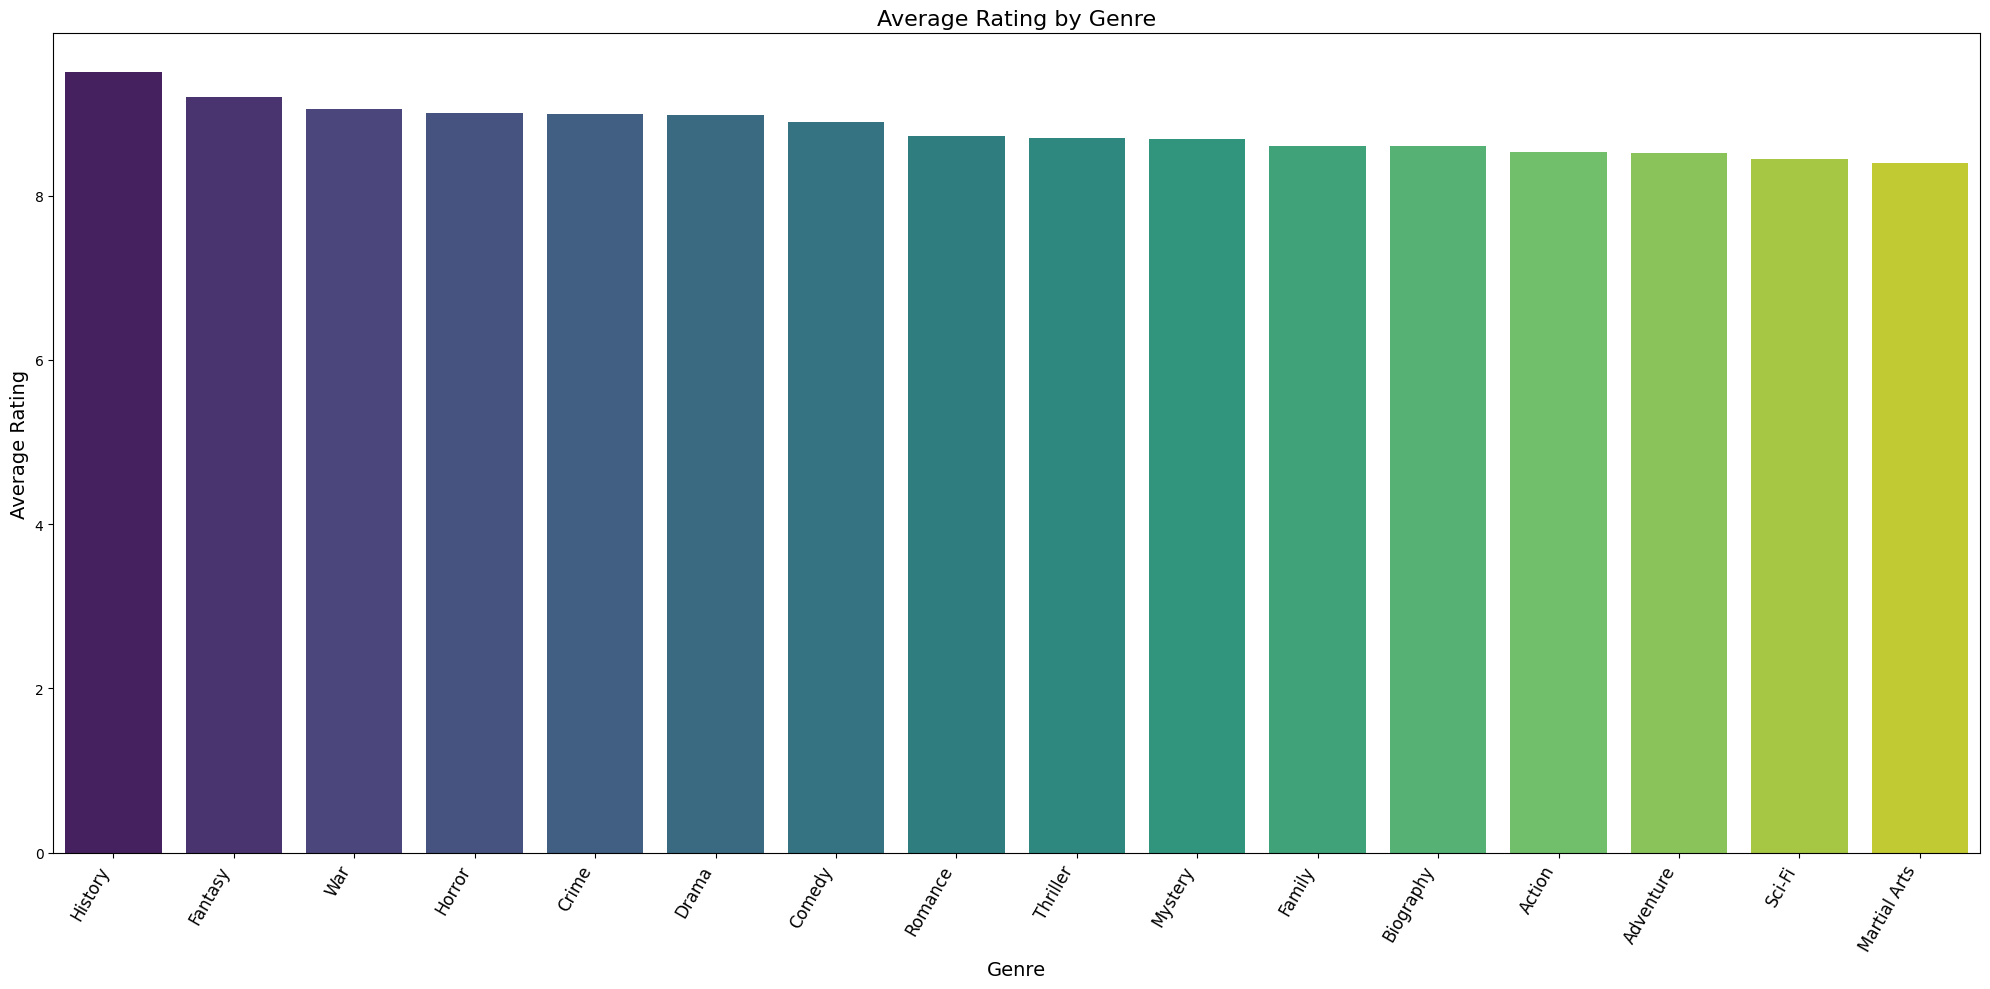

/tmp/ipython-input-1389509252.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_count_genre.index, y=movie_count_genre.values, palette="coolwarm")


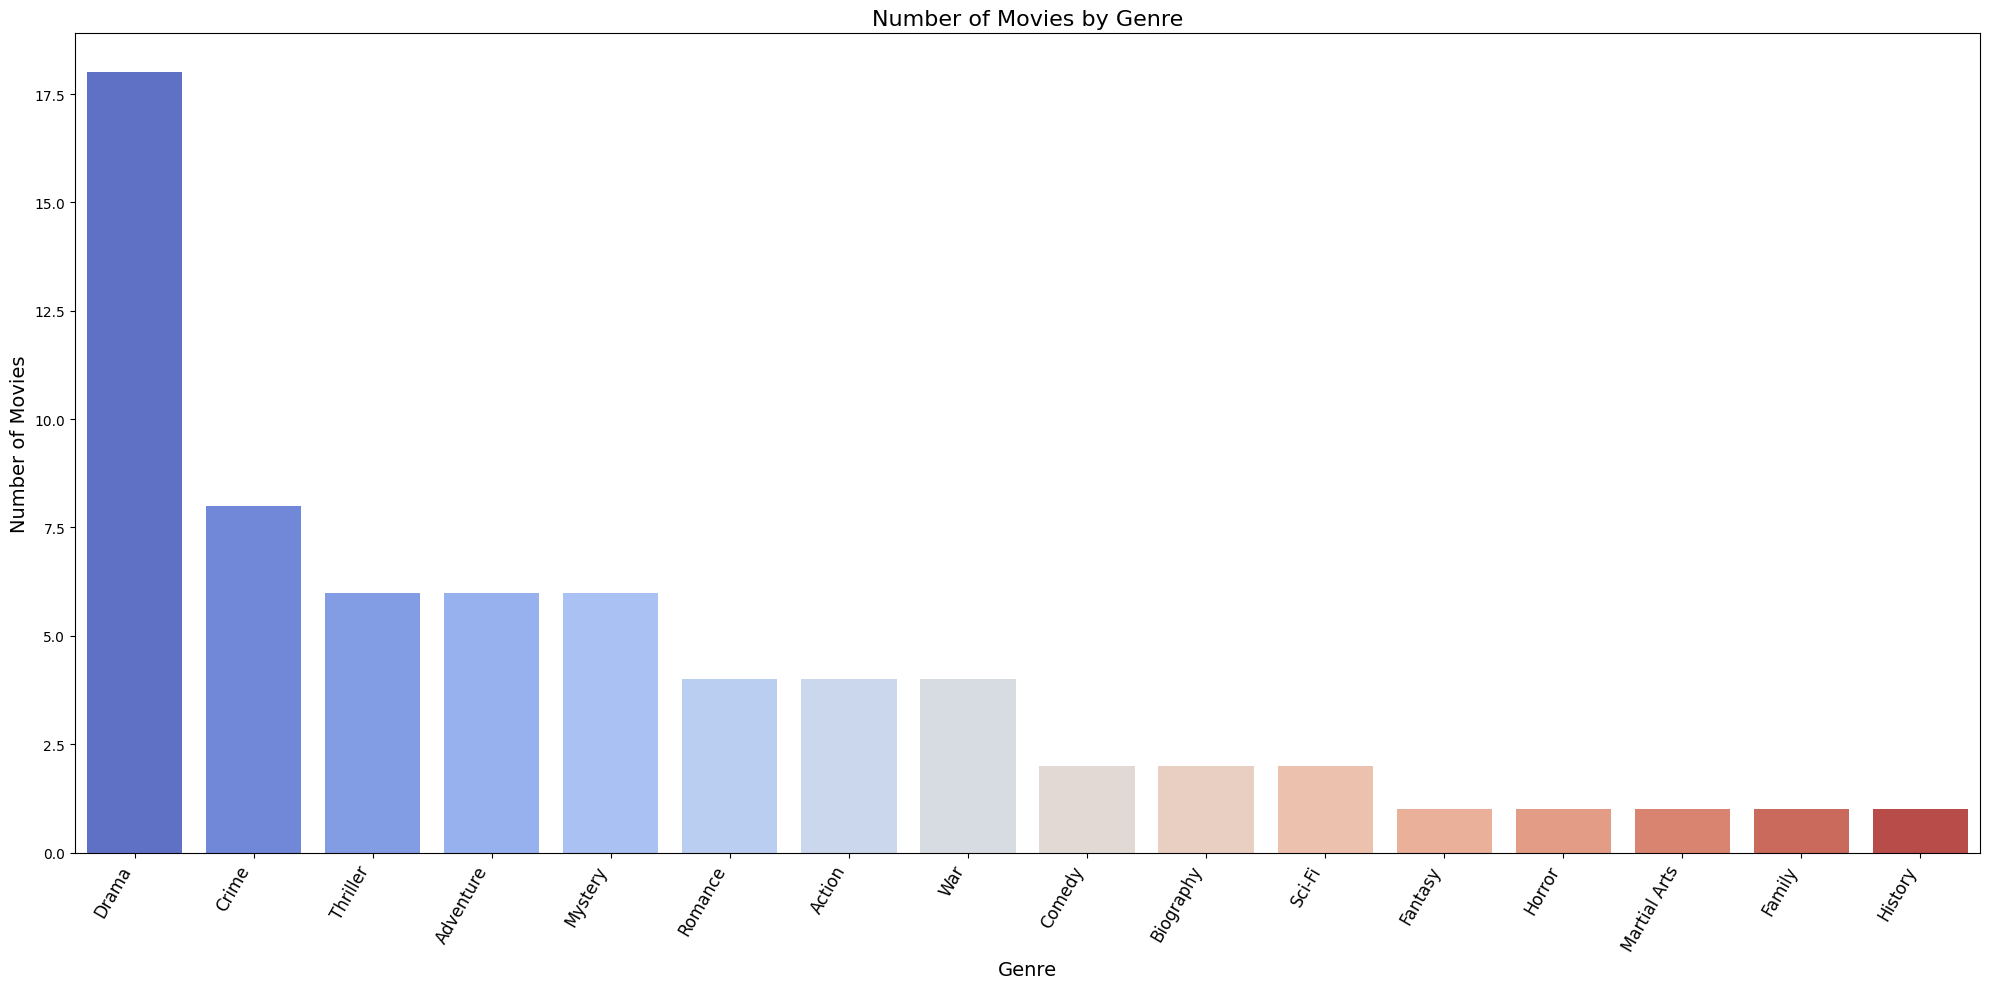

/tmp/ipython-input-1389509252.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_exploded, x='genres_en', y='rating', palette="Set2")


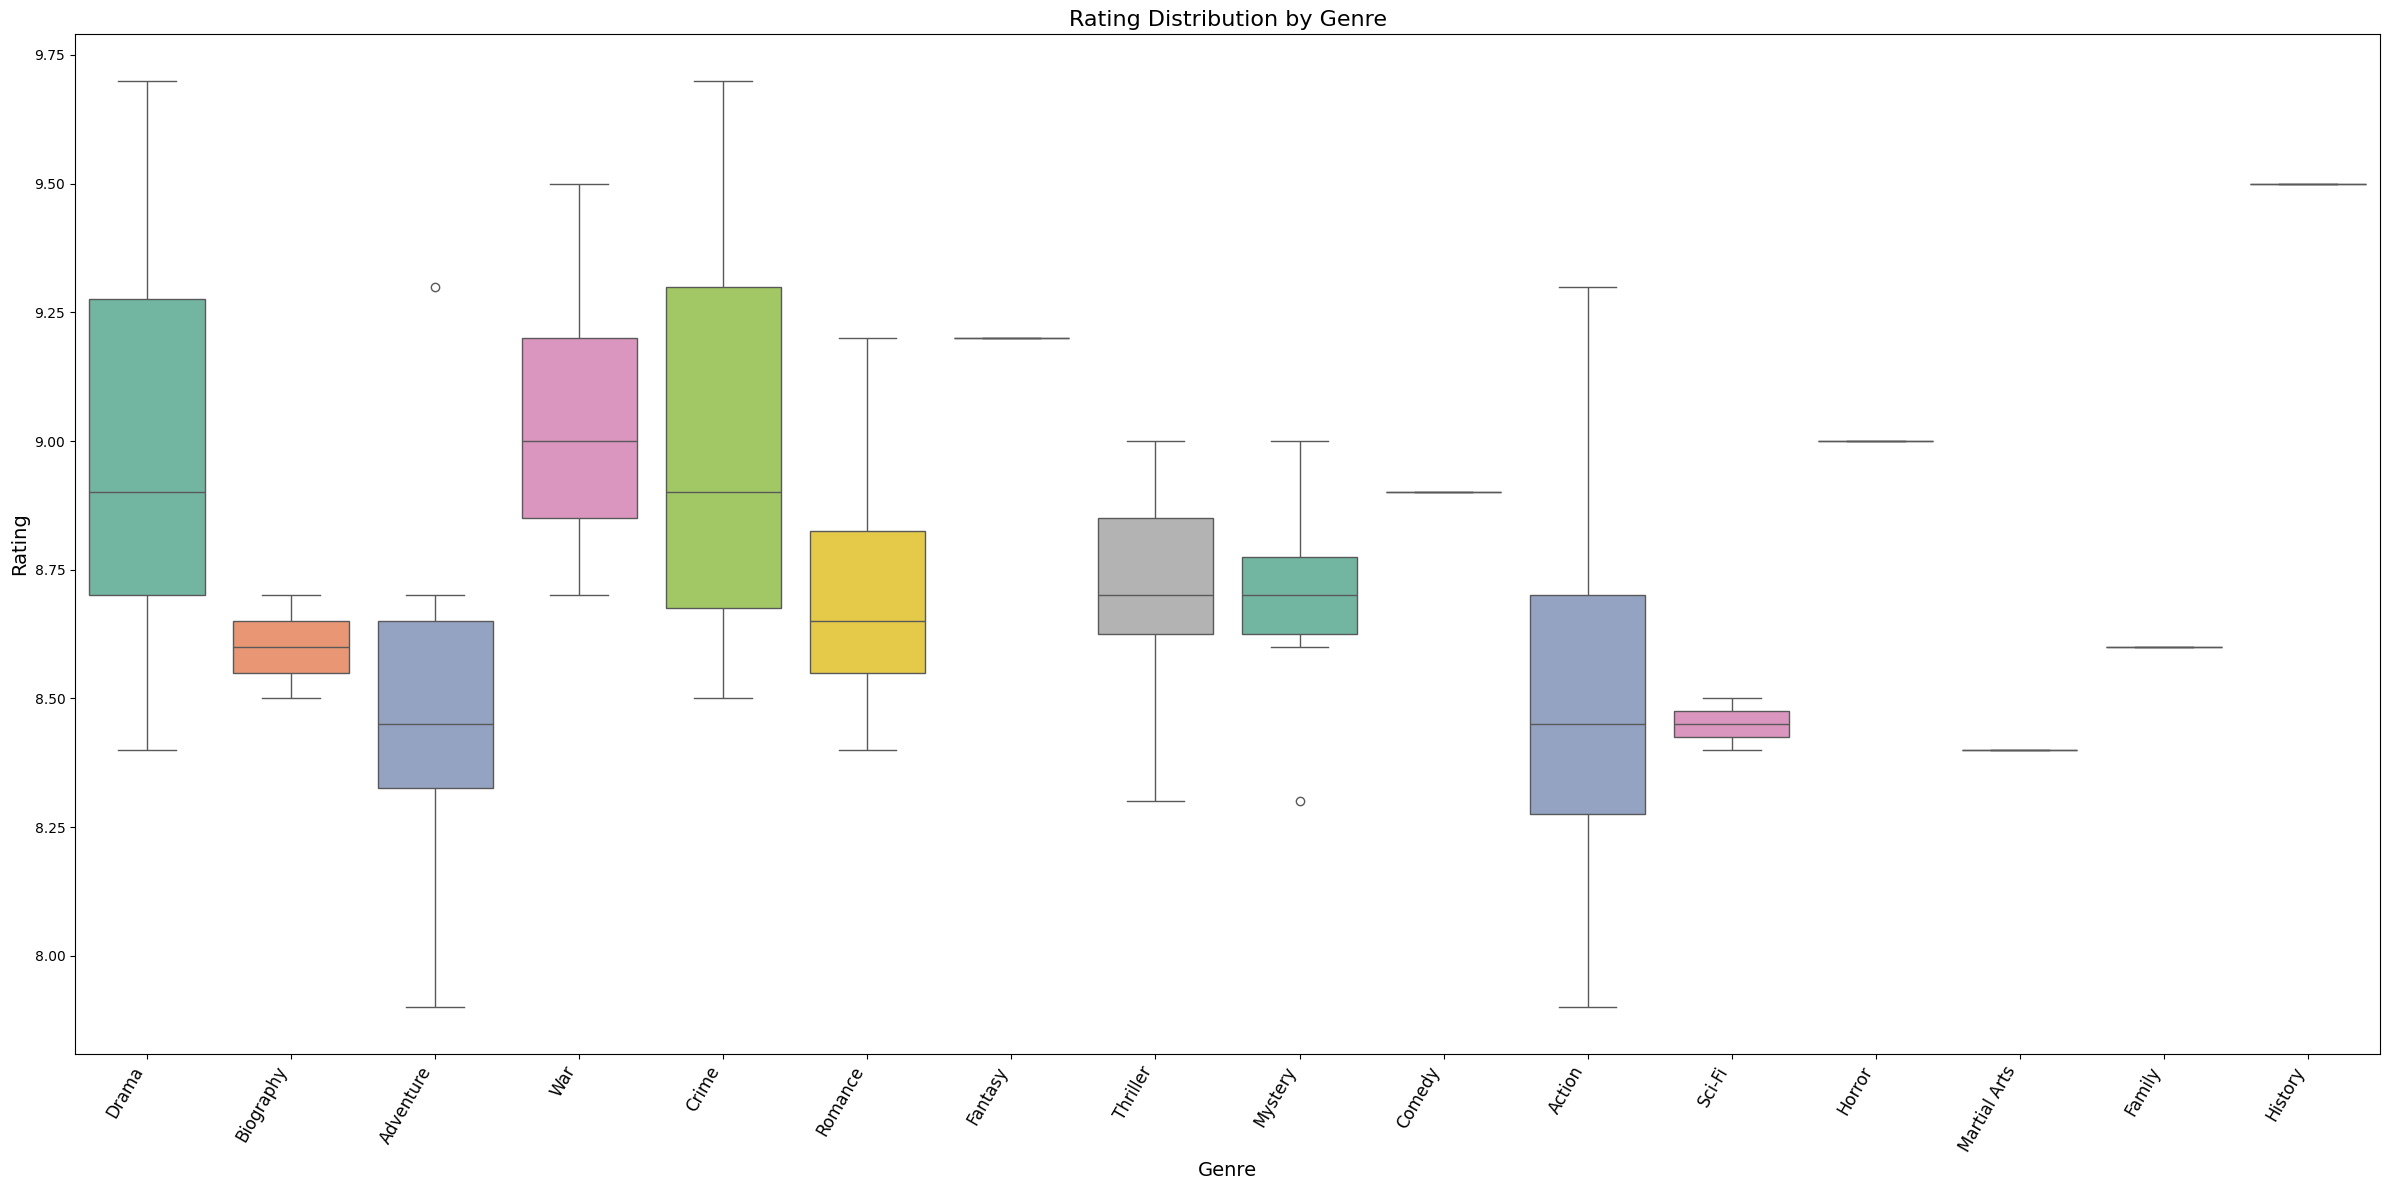

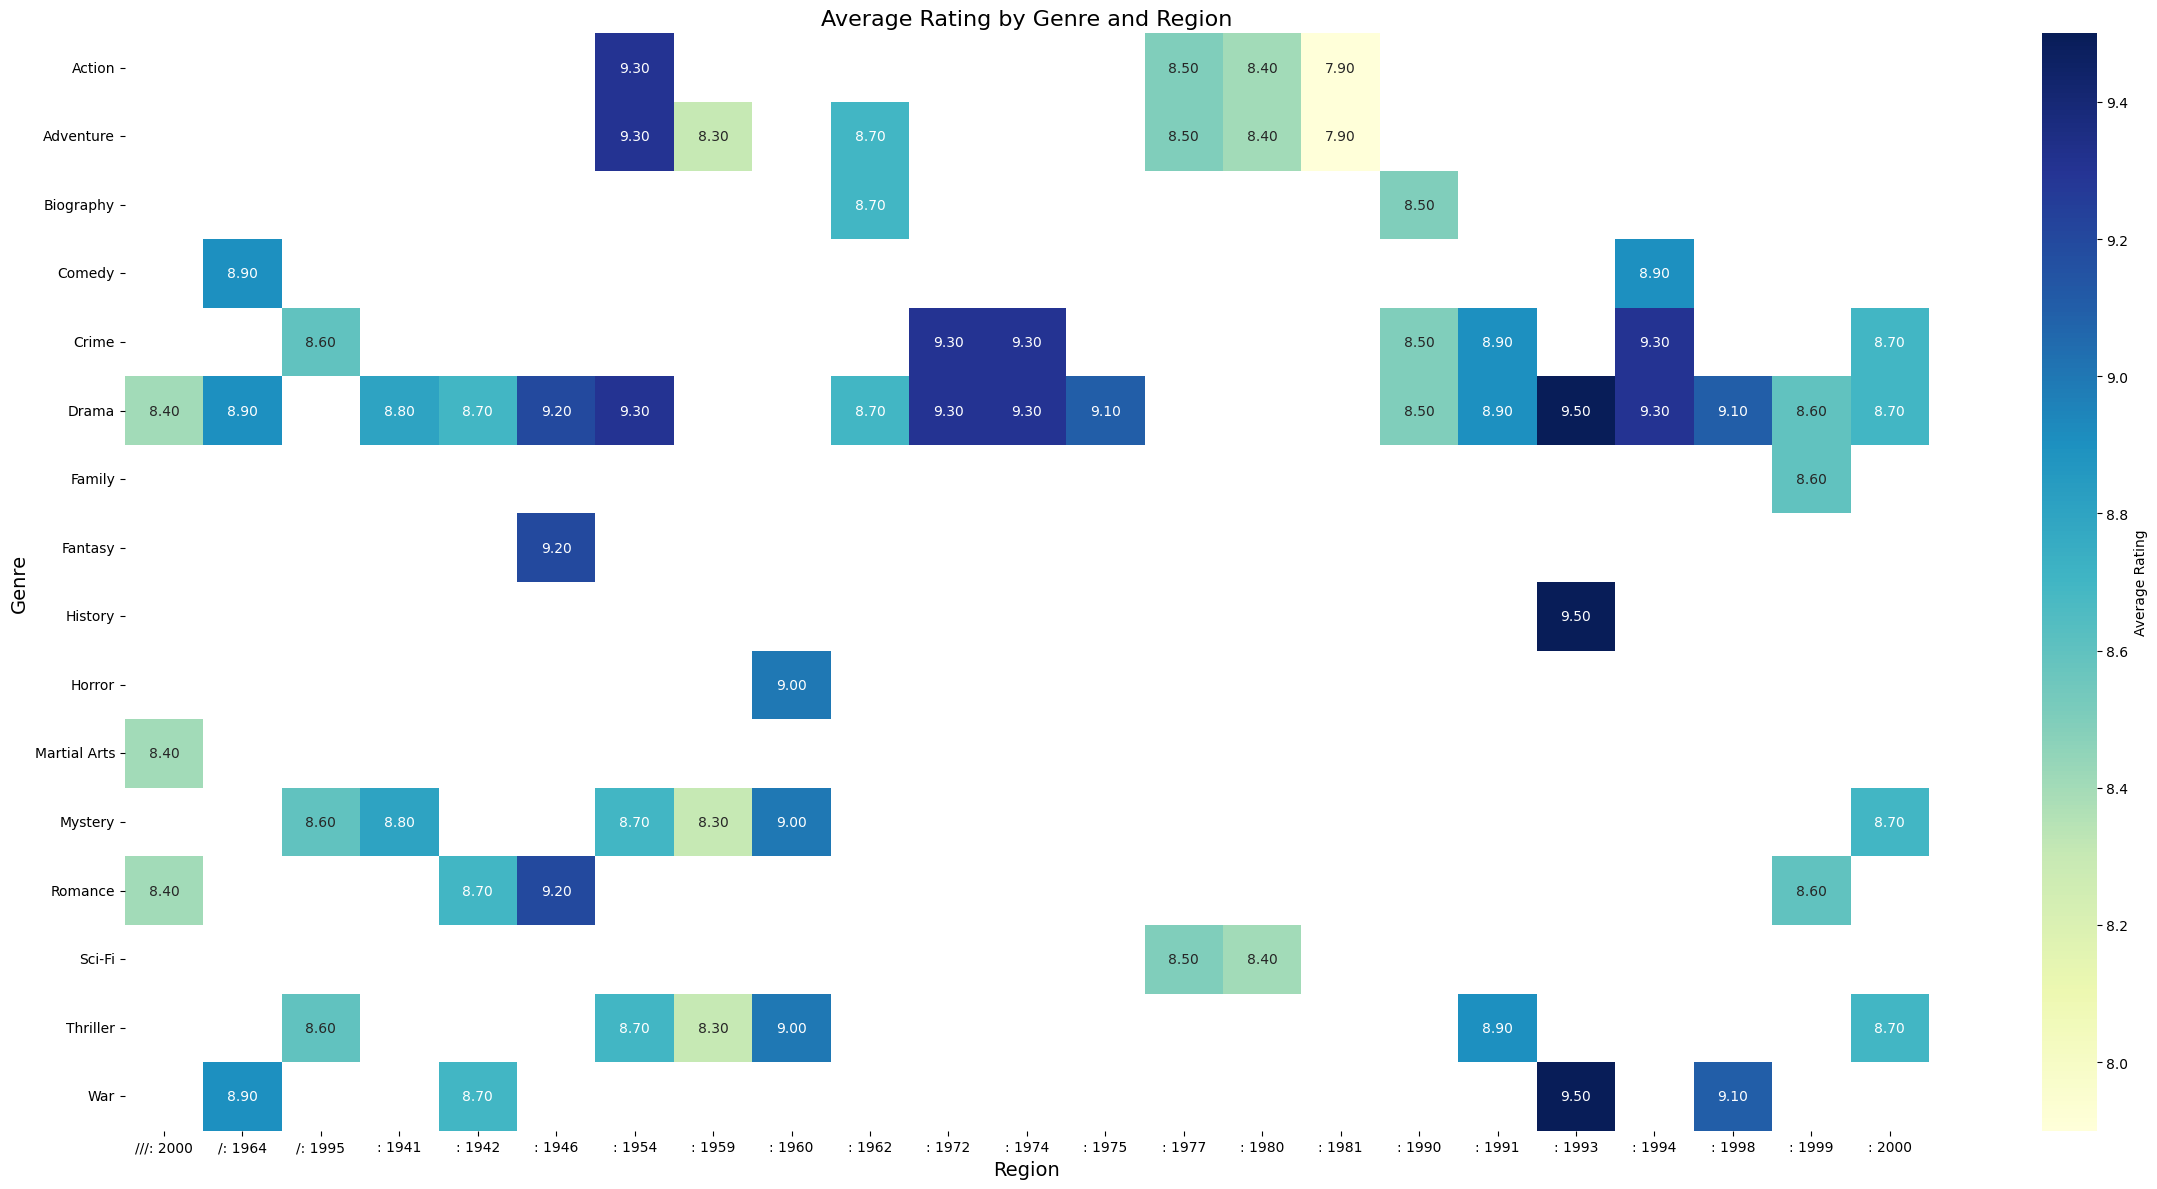

In [29]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Translation dictionaries ---
genre_map = {
    "剧情": "Drama",
    "喜剧": "Comedy",
    "动作": "Action",
    "爱情": "Romance",
    "科幻": "Sci-Fi",
    "动画": "Animation",
    "惊悚": "Thriller",
    "恐怖": "Horror",
    "犯罪": "Crime",
    "冒险": "Adventure",
    "奇幻": "Fantasy",
    "战争": "War",
    "历史": "History",
    "悬疑": "Mystery",
    "音乐": "Music",
    "歌舞": "Musical",
    "纪录片": "Documentary",
    "西部": "Western",
    "家庭": "Family",
    "传记": "Biography",
    "武侠": "Martial Arts"
}

region_map = {
    "中国大陆": "Mainland China",
    "香港": "Hong Kong",
    "台湾": "Taiwan",
    "美国": "USA",
    "日本": "Japan",
    "韩国": "Korea",
    "法国": "France",
    "英国": "UK",
    "德国": "Germany",
    "意大利": "Italy",
    "西班牙": "Spain"
}

# --- 2. Helper to remove any remaining Chinese characters ---
def remove_chinese(text):
    return re.sub(r"[\u4e00-\u9fff]", "", str(text))

# --- 3. Apply translations ---
df_exploded['genres_en'] = df_exploded['genres'].map(genre_map).fillna(df_exploded['genres'])
df_exploded['region_en'] = df_exploded['region'].map(region_map).fillna(df_exploded['region'])

# Remove any leftover Chinese
df_exploded['genres_en'] = df_exploded['genres_en'].apply(remove_chinese)
df_exploded['region_en'] = df_exploded['region_en'].apply(remove_chinese)

# --- 4. Create pivot table for heatmap ---
pivot = df_exploded.pivot_table(
    index='genres_en',
    columns='region_en',
    values='rating',
    aggfunc='mean'
)

# Remove any Chinese from pivot (just to be safe)
pivot.index = [remove_chinese(x) for x in pivot.index]
pivot.columns = [remove_chinese(x) for x in pivot.columns]

# --- 5. Plotting ---

# 1. Average rating per genre
avg_rating_genre = df_exploded.groupby('genres_en')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(20,10))
sns.barplot(x=avg_rating_genre.index, y=avg_rating_genre.values, palette="viridis")
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.ylabel("Average Rating", fontsize=14)
plt.xlabel("Genre", fontsize=14)
plt.title("Average Rating by Genre", fontsize=16)
plt.tight_layout()
plt.show()

# 2. Number of movies per genre
movie_count_genre = df_exploded['genres_en'].value_counts()

plt.figure(figsize=(20,10))
sns.barplot(x=movie_count_genre.index, y=movie_count_genre.values, palette="coolwarm")
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.ylabel("Number of Movies", fontsize=14)
plt.xlabel("Genre", fontsize=14)
plt.title("Number of Movies by Genre", fontsize=16)
plt.tight_layout()
plt.show()

# 3. Rating distribution per genre
plt.figure(figsize=(24,12))
sns.boxplot(data=df_exploded, x='genres_en', y='rating', palette="Set2")
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.ylabel("Rating", fontsize=14)
plt.xlabel("Genre", fontsize=14)
plt.title("Rating Distribution by Genre", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Heatmap: average rating by genre × region
plt.figure(figsize=(24,12))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Average Rating'}
)
plt.title("Average Rating by Genre and Region", fontsize=16)
plt.ylabel("Genre", fontsize=14)
plt.xlabel("Region", fontsize=14)
plt.tight_layout()
plt.show()